In [1]:
#importing the libraries required for the evaluation
import numpy as np
import rasterio
from pygeotools.lib import malib, warplib, iolib,geolib,filtlib
import numpy.ma as ma
%matplotlib inline
import matplotlib.pyplot as plt
import os
import pandas as pd
import matplotlib.mlab as mlab

In [2]:
#Warping files to disk
files=['WV_CArto-tile-0-last_masked.tif','B-tile-0.tif']
warplib.diskwarp_multi_fn(files, res='max', extent='intersection',t_srs='first',r='cubic')


Warping all inputs to the following:
Resolution: 10.0
Extent: [551565.0, 3029605.0, 704093.339, 3115655.0]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: cubic

1 of 2: WV_CArto-tile-0-last_masked.tif
nl: 8605 ns: 15253 res: 10.000
2 of 2: B-tile-0.tif
nl: 8605 ns: 15253 res: 10.000


[<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f97117df390> >,
 <osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f974428b3c0> >]

### Filtering slope to 30 and calculating stats..

In [3]:
DEM_Slope_filtered=filtlib.slope_fltr(os.path.splitext(files[1])[0]+'_warp.tif') # filtering DEM slope less 30 degrees
of='DEM_slope_0_30.tif'
iolib.writeGTiff(DEM_Slope_filtered, of,files[0])
ds_list=warplib.memwarp_multi_fn([files[0],of],res='max',extent='intersection',t_srs='first', r='cubic')
A=iolib.ds_getma(ds_list[1])
dh=iolib.ds_getma(ds_list[0])
l=[dh,A]
common_mask=malib.common_mask(l)
A1=ma.array(A,mask=common_mask)
dh1=ma.array(dh,mask=common_mask)
M=malib.print_stats(dh1)
Min=M[1]
Max=M[2]
Mean=M[3]
Std=M[4]
Med=M[5]
IQR=M[9]

gdaldem slope -co COMPRESS=LZW -co TILED=YES -co BIGTIFF=IF_SAFER B-tile-0_warp.tif B-tile-0_warp_slope.tif

Warping all inputs to the following:
Resolution: 10.0
Extent: [551565.0, 3029605.0, 704095.0, 3115655.0]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: cubic

1 of 2: WV_CArto-tile-0-last_masked.tif
2 of 2: DEM_slope_0_30.tif
count: 14057700 min: -99.99 max: 99.95 mean: -0.38 std: 7.09 med: -0.06 mad: 2.35 q1: -1.62 q2: 1.55 iqr: 3.17 mode: 0.10 p16: -2.69 p84: 2.59 spread: 2.64


### Mean +/- 3 *STD

In [4]:
Max_STD=Mean+3*Std
Min_STD=Mean-3*Std
filt_dh_std=ma.masked_outside(dh1, Min_STD, Max_STD)
M1=malib.print_stats(filt_dh_std)
print 'NMAD=%f' %(M1[6]*1.4826)
print '68.3Percentile=%f' %(np.percentile(ma.compressed(filt_dh_std),68.3))

count: 13753480 min: -21.64 max: 20.88 mean: -0.16 std: 4.19 med: -0.05 mad: 2.28 q1: -1.54 q2: 1.53 iqr: 3.07 mode: 0.17 p16: -2.53 p84: 2.52 spread: 2.53
NMAD=3.376621
68.3Percentile=1.013672


### Median +/- 1.5 Fold_Interquartile_Range

In [5]:
Q1=M[7]
Q3=M[8]
U=Q3+1.5*IQR
L=Q1-1.5*IQR
filt_dh_1_5_IQR=ma.masked_outside(dh1, L, U)
M2=malib.print_stats(filt_dh_1_5_IQR)
print 'NMAD=%f' %(M2[6]*1.4826)
print '68.3Percentile=%f' %(np.percentile(ma.compressed(filt_dh_1_5_IQR),68.3))


count: 12436387 min: -6.37 max: 6.30 mean: 0.04 std: 2.27 med: -0.01 mad: 1.99 q1: -1.31 q2: 1.39 iqr: 2.69 mode: 0.27 p16: -2.02 p84: 2.19 spread: 2.10
NMAD=2.955487
68.3Percentile=0.941895


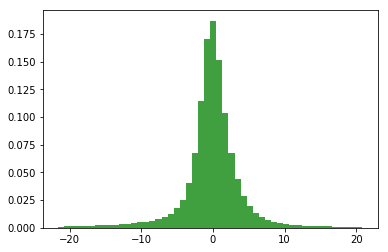

In [7]:
n, bins, patches = plt.hist(ma.compressed(filt_dh_std), 50, normed=1, facecolor='green', alpha=0.75)